# 1.环境配置

In [2]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd
from torch import functional as F
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import torch

D:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# 2.数据预处理

In [3]:
# 读入数据
class MyData(Data.Dataset):
    def __init__(self, feature, label):
        self.feature = feature # 特征
        self.label = label # 标签

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        return self.feature[idx], self.label[idx]

def load_data(batch_size):
    # 加载原始数据
    df_train = pd.read_csv(r'../input/heartpicture/train.csv')
    # 拆解heartbeat_signals
    train_signals = np.array(df_train['heartbeat_signals'].apply(lambda x: np.array(list(map(float, x.split(','))),dtype=np.float32)))
    train_labels = np.array(df_train['label'].apply(lambda x:float(x)),dtype=np.float32)  
    # 构建pytorch数据类
    train_data = MyData(train_signals,train_labels)
    # 构建pytorch数据集Dataloader
    train_loader = Data.DataLoader(dataset = train_data,batch_size=batch_size,shuffle=True)
    return train_data,train_loader

# 3.CNN定义

In [4]:
# 定义模型结构
class Net(nn.Module):

    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 1,out_channels = 16,kernel_size = 3,stride = 1,padding = 1)
        self.conv2 = nn.Conv1d(16,32,3,1,1)
        self.conv3 = nn.Conv1d(32,64,3,1,1)
        #self.conv4 = nn.Conv1d(64,64,5,1,2)   #可以考虑使用多几层的CNN和fc层，但相应的训练成本会更高
        #self.conv5 = nn.Conv1d(64,128,5,1,2)
        #self.conv6 = nn.Conv1d(128,128,5,1,2)
        self.maxpooling = nn.MaxPool1d(3,stride=2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3200,256)
        self.fc21 = nn.Linear(3200,16)
        self.fc22 = nn.Linear(16,256)
        self.fc3 = nn.Linear(256,4)

    def forward(self,x):
        x = x.view(x.size(0),1,x.size(1))
        x = self.relu(self.conv1(x))   #nn.Conv1d(in_channels = 1,out_channels = 32,kernel_size = 11,stride = 1,padding = 5)
        x = self.relu(self.conv2(x))
        x = self.maxpooling(x)
        x = self.relu(self.conv3(x))
        x = self.maxpooling(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x1 = self.relu(self.fc1(x))
        x21 = self.fc21(x)
        x22 = self.relu(x21)
        x2 = self.sigmoid(self.fc22(x22))
        x = self.fc3(x1+x2)
        return x

# 4.模型训练 

In [ ]:
def train_model(model,train_loader):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for i,data in enumerate(train_loader):
        inputs,labels = data
        predictions = model(inputs)
        loss = criterion(predictions,labels.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()*labels.size()[0]
        _,pred = torch.max(predictions,1)
        num_correct = (pred==labels).sum()
        running_acc += num_correct.item()
    return running_loss,running_acc

def loss_curve(list_loss,list_acc):
    epochs = np.arange(1,len(list_loss)+1) 
    fig,ax = plt.subplots()
    ax.plot(epochs,list_loss,label='loss')
    ax.plot(epochs,list_acc,label='accuracy')
    ax.set_xlabel('epoch')
    ax.set_ylabel('%')
    ax.set_title('loss & accuray ')
    ax.legend()

In [ ]:
# 调用定义的加载函数进行数据加载
batch_size = 64
train_data,train_loader = load_data(batch_size)

# 定义模型、loss function 
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001,weight_decay=1e-6)

# 循环150个epoch进行数据训练
list_loss,list_acc = [],[] 
for epoch in range(1,151):
    if (epoch%20==0):
        torch.save(model,'heart_beat{}.pth'.format(epoch//10)) #防止数据丢失，没训练20个epoch保存一次模型
    running_loss,running_acc=train_model(model,train_loader)
    list_loss.append(running_loss/train_data.__len__())
    list_acc.append(running_acc/train_data.__len__())
    print('Train {} epoch, Loss: {:.6f}, Acc:{:.6f}'.format(epoch,running_loss/train_data.__len__(),running_acc/train_data.__len__()))

# 绘图查看loss 和 accuracy曲线
loss_curve(list_loss,list_acc)

# 训练结果
### gpu时长有限，这里只训练了80个epoch
### 还可以一步优化，但训练时间较长，就没有进行网络的优化和调参了
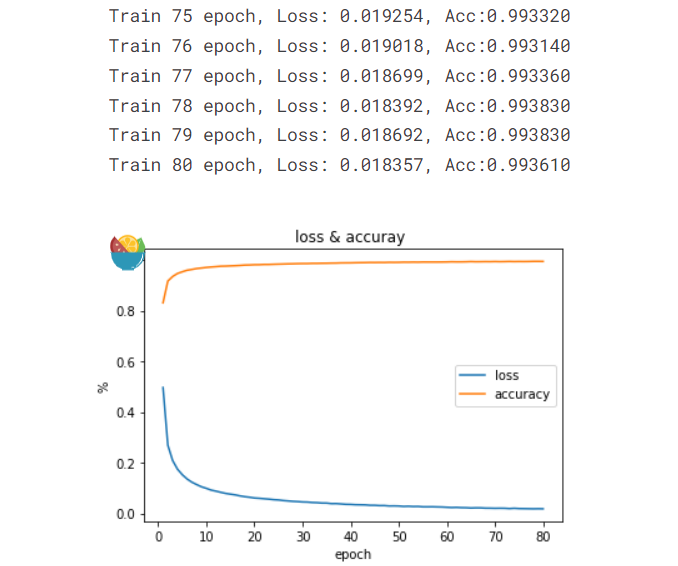
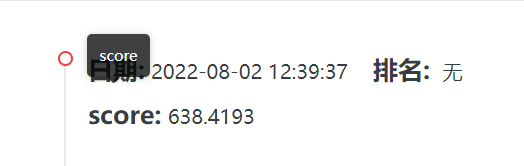